# **ML Modeling and Evaluation - Classification**

## Objectives

* Fit a feature engineering pipeline
* Fit a classification model to predict the health risk level of patients
* Evaluate the classification model performance
  
## Inputs

* Cleaned Maternal Health Risks dataset: outputs/cleaned/maternal-health-risk-dataset-clean.csv
* Instructions on feature engineering steps to take (see previous notebook)

## Outputs

* Train set (features and target)
* Test set (features and target)
* Feature engineering pipeline
* Modeling pipeline
* Feature importance plot

---

# Import Packages for Modelling and Evaluation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.outliers import Winsorizer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import StandardScaler

# feauture selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# grid search
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, recall_score

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Step 1: Load Data

Recall that we can directly load the cleaned dataset, since the only data cleaning we had to do was to remove 3 (suspectedly) erronous datapoints. There were no steps that could be performed in a data cleaning pipeline.

In [53]:
df = pd.read_csv('outputs/datasets/cleaned/maternal-health-risk-dataset-clean.csv')
print(df.shape)
df.head()

(1011, 7)


,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


---

# Step 2: ML pipeline with all Data

## ML Pipeline for Feature Engineering

In this section we will implement the ML pipeline for feature engineering. Recall that we do not need a DataCleaning Pipeline in this project due to an already clean dataset.

We implement a pipeline including the following steps:

* Outlier handling: Winsorizer for `["BloodSugar", "SystolicBP"]`
* Numerical Transformations: Box-Cox transformation for `["Age", "SystolicBP", "BloodSugar"]`
* SmartCorrelatedSelection (which will drop `["DiastolicBP"]`)

Define the feature engineering pipeline and call it

In [37]:
def PipelineFeatureEngineering():
    """
    Defines a pipeline including the feature engineering steps from above
    Winsorizer
    Box-Cox transformation
    SmartCorrelatedSelection
    """
    pipeline_base = Pipeline([
        ("Winsorizer", Winsorizer(
                            capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=["BloodSugar", "SystolicBP"]
                            )),
        ("BoxCoxTransformation", vt.BoxCoxTransformer(variables=[
                                                    "Age",
                                                    "SystolicBP",
                                                    "BloodSugar"
                                                    ])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                        variables=None,
                                        method="spearman",
                                        threshold=0.6,
                                        selection_method="variance"
                                        )),
    ])

    return pipeline_base


PipelineFeatureEngineering()

Pipeline(steps=[('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BloodSugar', 'SystolicBP'])),
                ('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimization

Define a pipeline that handles the ML Classifier modelling. It also includes feature scaling and feature selection which both need to happen after the feature engineering step.
We choose the StandardScaler to scale our features and the SelectFromModel to select the most important features to train the model.

In [38]:
def PipelineClassifier(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Next, we will conduct a hyperparameter optimization search to get the classification model as well as the hyperparameters that fit our dataset the best.

We start with a custom class for an efficient hyperparameter optimisation as well as algorithm search.

In [7]:
# The code for this class was taken from the Code Institute churnometer walkthrough project and adapted for this project


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClassifier(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### Split into Train and Test Set

Before getting into the hyperparameter optimisation we need to split our dataset into train and test set

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['RiskLevel'], axis=1),
    df['RiskLevel'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 6) (808,) (203, 6) (203,)


### Fit Feature Engineering Pipeline to Train Set

In [55]:

# Create feature engineering pipeline
pipeline_feat_eng = PipelineFeatureEngineering()

# fit on the train set and transform train set
X_train = pipeline_feat_eng.fit_transform(X_train)
# transform the test set
X_test = pipeline_feat_eng.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 5) (808,) (203, 5) (203,)


### **Handle Target Imbalance**

As mentioned in the data collection notebook the RiskLevel target column is moderately imbalanced. To improve model performance we perform SMOTE (Synthetic Minority Oversamplin Technique) to balance the train set by creating synthetic data. Importantly, we do this after fitting the feature engineering pipeline.

Plot the target distribution from the train set:

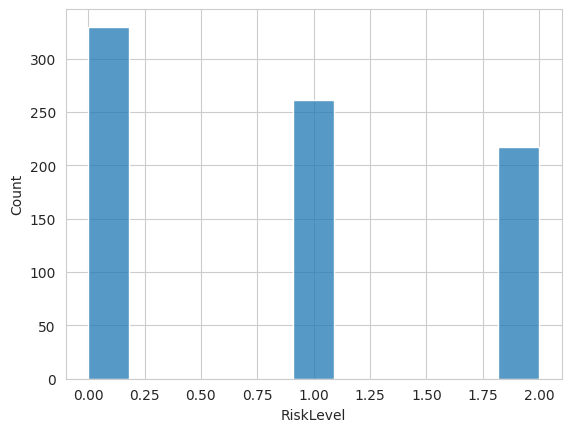

In [10]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

In [11]:
y_train.value_counts()

RiskLevel
0    330
1    261
2    217
Name: count, dtype: int64

**Resample the dataset with SMOTE**

The sample is slightly imbalanced with RiskLevel counts:
* low-risk (0): 330
* mid-risk (1): 261
* high-risk (2): 217

We decide to take a moderate oversampling approach of resampling both mid-risk and high-risk to 300. This is because, even though a totally balanced dataset might be advantageous for the classifier models, there is a risk of overfitting the models. Since our dataset is relatively small, generating too much synthetic high-risk data might overfit our model towards high-risk.

Fit and resample the test set:

In [26]:
# Create SMOTE object

oversample = SMOTE(
                sampling_strategy={
                1: 300,
                2: 300
                }, 
                random_state=0
                )

# fit oversample to train set and resample the train set
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(930, 5) (930,) (203, 5) (203,)


In [56]:
# Create SMOTE object

oversample = SMOTE(
                sampling_strategy={
                1: 300,
                2: 300
                }, 
                random_state=0
                )

# fit oversample to train set and resample the train set
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(930, 5) (930,) (203, 5) (203,)


Check the target distibution for the train set again after resampling. It is now more balanced but purposefully not completely balanced.

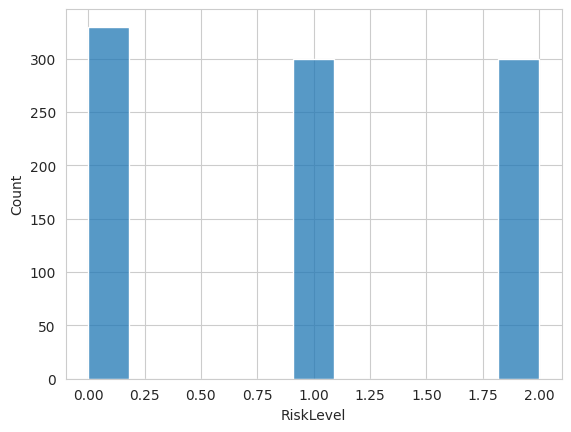

In [57]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

### Grid Search for hyperparameter optimisation

We use Grid Search CV to conduct a hypermarameter optimisation search. The first step is to focus on finding the most suitable algorithm before optimizing its hyperparameters.

So let us first search through many different classification algorithms using only their standard hyperparameters for efficiency. Next, we will choose the best algorithm and conduct an extensive hyperparameter optimisation search on this specific algorithm (or several good ones).

In [16]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "AdaBoostClassifier": {},
    "ExtraTreesClassifier": {},
    "GradientBoostingClassifier": {},
    "XGBClassifier": {},
}

We perform the grid search with the goal to optimize for the recall of high-risk level predictions as stated in the business case.

In [17]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, labels=[2], average=None),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [18]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111
2,RandomForestClassifier,0.733333,0.87,0.933333,0.073333
5,GradientBoostingClassifier,0.733333,0.823333,0.866667,0.051208
6,XGBClassifier,0.75,0.82,0.9,0.05099
4,ExtraTreesClassifier,0.733333,0.813333,0.866667,0.05416
1,DecisionTreeClassifier,0.583333,0.783333,0.883333,0.113039
0,LogisticRegression,0.65,0.766667,0.866667,0.084327


In [16]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,AdaBoostClassifier,0.8,0.88,0.933333,0.04397
2,RandomForestClassifier,0.766667,0.86,0.933333,0.056372
6,XGBClassifier,0.766667,0.836667,0.883333,0.038586
5,GradientBoostingClassifier,0.766667,0.823333,0.866667,0.035901
4,ExtraTreesClassifier,0.766667,0.816667,0.866667,0.042164
1,DecisionTreeClassifier,0.566667,0.753333,0.85,0.100775
0,LogisticRegression,0.6,0.753333,0.883333,0.097411


To avoid biasing the model towards only the high-risk level recall, we also perform a grid search optimizing for the recall averaged over all three classes and compare the results. Note that we choose the unweighted macro average here, since we do not want to put more emphasis on low-risk which is the heaviest class.

In [19]:
quick_search_ave = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search_ave.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [20]:
grid_search_summary_ave, grid_search_pipelines_ave = quick_search_ave.score_summary(sort_by='mean_score')
grid_search_summary_ave 

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestClassifier,0.65404,0.784949,0.839899,0.069166
4,ExtraTreesClassifier,0.659091,0.713232,0.762626,0.033576
5,GradientBoostingClassifier,0.664141,0.710404,0.741414,0.027154
6,XGBClassifier,0.664646,0.708182,0.720707,0.021846
1,DecisionTreeClassifier,0.595455,0.70101,0.795455,0.069823
3,AdaBoostClassifier,0.60303,0.643333,0.691919,0.038533
0,LogisticRegression,0.567677,0.6,0.633838,0.02597


In [20]:
grid_search_summary_ave, grid_search_pipelines_ave = quick_search_ave.score_summary(sort_by='mean_score')
grid_search_summary_ave 

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestClassifier,0.665152,0.763939,0.845455,0.064243
6,XGBClassifier,0.670202,0.726667,0.779293,0.034602
4,ExtraTreesClassifier,0.670202,0.717677,0.757071,0.028547
5,GradientBoostingClassifier,0.669192,0.71596,0.741414,0.025667
1,DecisionTreeClassifier,0.606566,0.683232,0.74596,0.046959
3,AdaBoostClassifier,0.622727,0.653636,0.69697,0.033474
0,LogisticRegression,0.573232,0.601414,0.623737,0.021223


AdaBoost shows the best performance when we optimize for high-risk recall only, but is much weaker when looking at all classes, which could be a sign that the model is not well suited for predicting health risk levels. Even though it has good recall on high-risk we still need a reasonably high performance on the other classes as well. RandomForestClassifier is the second best performer when optimizing for high-risk recall and best performer when optimizing for averaged recall. Thus, we will take these two algorithms into the next round of more extensive hyperparameter search.
The runner up in the averaged recall optimization is XGBClassifier, however its performance is significantly lower than RandomForestClassier and hence, it is not worth it to consider it further.

In [63]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# Conduct an extensive hyperparameter search:
# We get inspiration for common and useful hyperparameter values from 
# the Code Institute course and from the algorithms' documentations
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [100,50,140],
        'model__max_depth': [None,4, 8, 12, 15],
        'model__min_samples_split': [2,50],
        'model__min_samples_leaf': [1,50],
        'model__max_leaf_nodes': [None,50],
    },
    "AdaBoostClassifier": {
        'model__n_estimators': [50,25,80,150],
        'model__learning_rate':[1,0.1, 2],
    }
}

Start with the optimization for high-risk level recall again.

In [64]:
search_hr = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search_hr.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, labels=[2], average=None),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [65]:
grid_search_summary_hr, grid_search_pipelines_hr = search_hr.score_summary(sort_by='mean_score')
grid_search_summary_hr 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
121,AdaBoostClassifier,0.840909,0.875899,0.930233,0.033236,NaN,NaN,NaN,NaN,25,1
122,AdaBoostClassifier,0.818182,0.871353,0.930233,0.038799,NaN,NaN,NaN,NaN,80,1
123,AdaBoostClassifier,0.75,0.857717,0.930233,0.060822,NaN,NaN,NaN,NaN,150,1
2,RandomForestClassifier,0.795455,0.857611,0.906977,0.045388,None,None,1,2,140,NaN
96,RandomForestClassifier,0.795455,0.857611,0.930233,0.052048,15,None,1,2,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...
41,RandomForestClassifier,0.744186,0.801903,0.860465,0.040055,4,50,1,50,140,NaN
127,AdaBoostClassifier,0.568182,0.798203,0.906977,0.120584,NaN,NaN,NaN,NaN,150,0.1
126,AdaBoostClassifier,0.590909,0.733615,0.860465,0.09566,NaN,NaN,NaN,NaN,80,0.1
125,AdaBoostClassifier,0.568182,0.705497,0.837209,0.110313,NaN,NaN,NaN,NaN,25,0.1


In [23]:
grid_search_summary_hr, grid_search_pipelines_hr = search_hr.score_summary(sort_by='mean_score')
grid_search_summary_hr 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
121,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111,NaN,NaN,NaN,NaN,25,1
120,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111,NaN,NaN,NaN,NaN,50,1
56,RandomForestClassifier,0.816667,0.87,0.933333,0.046428,8,None,50,2,140,NaN
95,RandomForestClassifier,0.816667,0.87,0.933333,0.046428,12,50,50,50,140,NaN
20,RandomForestClassifier,0.816667,0.87,0.933333,0.046428,None,50,50,2,140,NaN
...,...,...,...,...,...,...,...,...,...,...,...
49,RandomForestClassifier,0.733333,0.823333,0.866667,0.046667,8,None,1,2,50,NaN
131,AdaBoostClassifier,0.7,0.8,0.883333,0.060553,NaN,NaN,NaN,NaN,150,2
126,AdaBoostClassifier,0.616667,0.77,0.883333,0.100775,NaN,NaN,NaN,NaN,80,0.1
125,AdaBoostClassifier,0.633333,0.72,0.833333,0.083267,NaN,NaN,NaN,NaN,25,0.1


In [23]:
grid_search_summary_hr, grid_search_pipelines_hr = search_hr.score_summary(sort_by='mean_score')
grid_search_summary_hr 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
120,AdaBoostClassifier,0.8,0.88,0.933333,0.04397,NaN,NaN,NaN,NaN,50,1
122,AdaBoostClassifier,0.8,0.88,0.933333,0.04397,NaN,NaN,NaN,NaN,80,1
121,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111,NaN,NaN,NaN,NaN,25,1
43,RandomForestClassifier,0.816667,0.87,0.933333,0.046428,4,50,50,2,50,NaN
22,RandomForestClassifier,0.816667,0.87,0.933333,0.046428,None,50,50,50,50,NaN
...,...,...,...,...,...,...,...,...,...,...,...
128,AdaBoostClassifier,0.666667,0.793333,0.866667,0.079303,NaN,NaN,NaN,NaN,50,2
129,AdaBoostClassifier,0.733333,0.793333,0.85,0.047842,NaN,NaN,NaN,NaN,25,2
126,AdaBoostClassifier,0.616667,0.766667,0.866667,0.094868,NaN,NaN,NaN,NaN,80,0.1
124,AdaBoostClassifier,0.633333,0.73,0.866667,0.092135,NaN,NaN,NaN,NaN,50,0.1


Now optimize for macro averaged recall for all three classes.

In [24]:
search_ave = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search_ave.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [25]:
grid_search_summary_ave, grid_search_pipelines_ave = search_ave.score_summary(sort_by='mean_score')
grid_search_summary_ave 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
97,RandomForestClassifier,0.65404,0.78596,0.845455,0.068765,15,None,1,2,50,NaN
96,RandomForestClassifier,0.65404,0.785051,0.845455,0.068393,15,None,1,2,100,NaN
0,RandomForestClassifier,0.65404,0.784949,0.839899,0.069166,None,None,1,2,100,NaN
1,RandomForestClassifier,0.65404,0.784848,0.839899,0.068672,None,None,1,2,50,NaN
72,RandomForestClassifier,0.65404,0.784848,0.845455,0.068118,12,None,1,2,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...
121,AdaBoostClassifier,0.599495,0.634242,0.671212,0.023075,NaN,NaN,NaN,NaN,25,1
122,AdaBoostClassifier,0.594949,0.630808,0.666162,0.02673,NaN,NaN,NaN,NaN,80,1
126,AdaBoostClassifier,0.562121,0.603939,0.633838,0.032186,NaN,NaN,NaN,NaN,80,0.1
124,AdaBoostClassifier,0.534343,0.573939,0.617172,0.035961,NaN,NaN,NaN,NaN,50,0.1


In [26]:
grid_search_summary_ave, grid_search_pipelines_ave = search_ave.score_summary(sort_by='mean_score')
grid_search_summary_ave 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
72,RandomForestClassifier,0.665152,0.76798,0.840404,0.066093,12,None,1,2,100,NaN
73,RandomForestClassifier,0.676263,0.767475,0.845455,0.064224,12,None,1,2,50,NaN
74,RandomForestClassifier,0.665152,0.766768,0.845455,0.066809,12,None,1,2,140,NaN
96,RandomForestClassifier,0.665152,0.76596,0.85101,0.066413,15,None,1,2,100,NaN
98,RandomForestClassifier,0.655556,0.765051,0.856566,0.070847,15,None,1,2,140,NaN
...,...,...,...,...,...,...,...,...,...,...,...
123,AdaBoostClassifier,0.611616,0.643737,0.679798,0.024252,NaN,NaN,NaN,NaN,150,1
129,AdaBoostClassifier,0.578788,0.63404,0.680303,0.034971,NaN,NaN,NaN,NaN,25,2
126,AdaBoostClassifier,0.562121,0.611717,0.633838,0.02657,NaN,NaN,NaN,NaN,80,0.1
124,AdaBoostClassifier,0.534343,0.576162,0.617172,0.033686,NaN,NaN,NaN,NaN,50,0.1


To come to a decision, we will look at the three best models in more detail and compute the performance metrics for all three of them. Based on the confusion matrices and performance scores we will decide which model to study further.

We continue with:
* AdaBoostClassifier with best results for high-risk recall (mean score 0.88)
* RandomForestClassifier with best results for high-risk recall (mean score 0.87)
* RandomForestClassifier with best results for averaged recall (mean score 0.78)

#### Get models programmatically:

Best model for averaged recall

In [26]:
best_model_ave = grid_search_summary_ave.iloc[0,0]
best_model_ave

'RandomForestClassifier'

Best AdaBoost model for high-risk recall

In [27]:
best_model_hr_ada = grid_search_summary_hr.iloc[0,0]
best_model_hr_ada

'AdaBoostClassifier'

Best RandomForest model for high-risk recall

In [28]:
best_model_hr_rf = grid_search_summary_hr.iloc[3,0]
best_model_hr_rf

'RandomForestClassifier'

Get the best parameters for each model

In [47]:

best_parameters_ave = grid_search_pipelines_ave[best_model_ave].best_params_
best_parameters_ave

{'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [30]:
best_parameters_hr_ada = grid_search_pipelines_hr[best_model_hr_ada].best_params_
best_parameters_hr_ada

{'model__learning_rate': 1, 'model__n_estimators': 50}

In [31]:
best_parameters_hr_rf = grid_search_pipelines_hr[best_model_hr_rf].best_params_
best_parameters_hr_rf

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Define the best clf pipeline (optimized for recall averaged over the three classes).

In [32]:
pipeline_clf_ave = grid_search_pipelines_ave[best_model_ave].best_estimator_
pipeline_clf_ave

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=15, n_estimators=50,
                                        random_state=0))])

In [37]:
pipeline_clf_hr_ada = grid_search_pipelines_hr[best_model_hr_ada].best_estimator_
pipeline_clf_hr_ada

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model', AdaBoostClassifier(learning_rate=1, random_state=0))])

In [33]:
pipeline_clf_hr_rf = grid_search_pipelines_hr[best_model_hr_rf].best_estimator_
pipeline_clf_hr_rf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=140,
                                        random_state=0))])

### Evalueate Pipelines on Train and Test Sets

We evaluate the three classifier pipelines on the train and the test set to decide which one is best suitable for our project.

In [11]:
# Code inspiration for these functions was taken from the Code Institute
# Churnometer walkthrough project

def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Metrics defined in the business case:
* Recall for high-risk should be at least 70% (due to small dataset) but ideally over 80%

Test RandomForestClassifier optimized for averaged recall:

In [35]:

clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_ave,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              292              16                3
Prediction mid risk               34             271                8
Prediction high risk               4              13              289


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.94      0.88      0.91       330
    mid risk       0.87      0.90      0.88       300
   high risk       0.94      0.96      0.95       300

    accuracy                           0.92       930
   macro avg       0.92      0.92      0.92       930
weighted avg       0.92      0.92      0.92       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              13                1
Prediction mid risk               11              60               

Evaluate AdaBoost classifier which gives best results for recall on high risk but decreased performance is expected on other classes.

We will check whether the trade off is worth it or too much to accept.

In [38]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_hr_ada,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              247             110               30
Prediction mid risk               80             132                4
Prediction high risk               3              58              266


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.64      0.75      0.69       330
    mid risk       0.61      0.44      0.51       300
   high risk       0.81      0.89      0.85       300

    accuracy                           0.69       930
   macro avg       0.69      0.69      0.68       930
weighted avg       0.69      0.69      0.68       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               55              28                6
Prediction mid risk               17              39               

Evaluate Random Forest classifier which gives results almost as good for recall on high risk and is expected to give better performance on other classes compared to AdaBoost.

In [39]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_hr_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              261             103               26
Prediction mid risk               63             135                9
Prediction high risk               6              62              265


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.67      0.79      0.72       330
    mid risk       0.65      0.45      0.53       300
   high risk       0.80      0.88      0.84       300

    accuracy                           0.71       930
   macro avg       0.71      0.71      0.70       930
weighted avg       0.70      0.71      0.70       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               57              27                5
Prediction mid risk               14              40               

We see that the performance of the RandomForestClassifier that was optimized for averaged recall is better than the models optimized on high risk recall. The latter two only have slightly better high-risk recall, while the other metrics (especially for predicting mid risk) are generally worse.

However, it in the best model we note that the performance on the test set is worse then in the train set. Most notably the recall for high-risk class goes from 88% to 78%, that is a drop in 10 percentage points. Since our dataset is relatively small, it could be acceptable and due to fluctuation in the (small) test set, but it is a notable difference and needs further investigation since it could be a hint of some overfitting happening.

We will investigate the random forest model further and conduct another grid search with more hyperparameters trying to avoid overfitting.

### Test-Train Gap vs. Recall Analysis

We continue with a more detailes study of the influence of the max_depth hyperparameter on the train-test-gap compared to the general performance, especially recall.

In [ ]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0)
}

params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [100, 140, 200],
        # step 1: allow max_depth up to 15
        # 'model__max_depth': [6, 8, 10, 15],
        # step 2: allow max_depth up to 10
        'model__max_depth': [6, 8, 10],
        # step 3: limit max_depth to max 8
        # 'model__max_depth': [6, 8],
        'model__min_samples_split': [2, 5, 50],
        'model__min_samples_leaf': [1, 2, 20],
        'model__max_leaf_nodes': [None]
    }
}

In [109]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


max_depth 15:

In [95]:
grid_search_summary_ave_rf, grid_search_pipelines_ave_rf = search.score_summary(sort_by='mean_score')
grid_search_summary_ave_rf

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
54,RandomForestClassifier,0.65404,0.785051,0.845455,0.068393,15,None,1,2,100
56,RandomForestClassifier,0.65404,0.784848,0.845455,0.0687,15,None,1,2,200
55,RandomForestClassifier,0.644444,0.783131,0.845455,0.072813,15,None,1,2,140
57,RandomForestClassifier,0.65404,0.777778,0.823232,0.062335,15,None,1,5,100
58,RandomForestClassifier,0.65404,0.776869,0.812626,0.061537,15,None,1,5,140
...,...,...,...,...,...,...,...,...,...,...
61,RandomForestClassifier,0.65202,0.703535,0.727778,0.027546,15,None,1,50,140
71,RandomForestClassifier,0.640909,0.703434,0.727273,0.03233,15,None,2,50,200
70,RandomForestClassifier,0.644949,0.702222,0.727778,0.03051,15,None,2,50,140
42,RandomForestClassifier,0.633838,0.701313,0.733333,0.035033,8,None,2,50,100


max_depth 10:

In [112]:
grid_search_summary_ave_rf, grid_search_pipelines_ave_rf = search.score_summary(sort_by='mean_score')
grid_search_summary_ave_rf

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
55,RandomForestClassifier,0.669192,0.779798,0.818687,0.055801,10,None,1,2,140
54,RandomForestClassifier,0.669192,0.778586,0.818687,0.055182,10,None,1,2,100
56,RandomForestClassifier,0.653535,0.776667,0.818687,0.062013,10,None,1,2,200
29,RandomForestClassifier,0.708081,0.763939,0.801515,0.031285,8,None,1,2,200
58,RandomForestClassifier,0.663636,0.763434,0.796465,0.050311,10,None,1,5,140
...,...,...,...,...,...,...,...,...,...,...
70,RandomForestClassifier,0.644949,0.702222,0.727778,0.03051,10,None,2,50,140
61,RandomForestClassifier,0.651515,0.701313,0.726768,0.026846,10,None,1,50,140
42,RandomForestClassifier,0.633838,0.701313,0.733333,0.035033,8,None,2,50,100
69,RandomForestClassifier,0.644949,0.701212,0.721717,0.028405,10,None,2,50,100


max_depth 8:

In [79]:
grid_search_summary_ave_rf, grid_search_pipelines_ave_rf = search.score_summary(sort_by='mean_score')
grid_search_summary_ave_rf

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
29,RandomForestClassifier,0.708081,0.763939,0.801515,0.031285,8,None,1,2,200
32,RandomForestClassifier,0.708081,0.759596,0.793434,0.027985,8,None,1,5,200
27,RandomForestClassifier,0.668182,0.758283,0.806566,0.047753,8,None,1,2,100
28,RandomForestClassifier,0.668182,0.758182,0.801515,0.047583,8,None,1,2,140
36,RandomForestClassifier,0.668687,0.757172,0.809596,0.049134,8,None,2,2,100
38,RandomForestClassifier,0.668687,0.756263,0.79899,0.046655,8,None,2,2,200
37,RandomForestClassifier,0.668687,0.754141,0.793939,0.04579,8,None,2,2,140
30,RandomForestClassifier,0.668182,0.752828,0.793434,0.044031,8,None,1,5,100
31,RandomForestClassifier,0.668182,0.751616,0.793434,0.043193,8,None,1,5,140
39,RandomForestClassifier,0.668687,0.748788,0.790404,0.043602,8,None,2,5,100


Note the averaged recall score is 76% and slightly less than before, we will check whether the performance on the test set improves compared to the train set to decide whether that trade-off is worth it.

In [113]:
best_model_ave_rf = grid_search_summary_ave_rf.iloc[0,0]
best_model_ave_rf

'RandomForestClassifier'

In [114]:

best_parameters_ave_rf = grid_search_pipelines_ave_rf[best_model_ave_rf].best_params_
best_parameters_ave_rf

{'model__max_depth': 10,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [115]:

pipeline_clf_rf = grid_search_pipelines_ave_rf[best_model_ave_rf].best_estimator_
pipeline_clf_rf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=140,
                                        random_state=0))])

max_depth 15:

In [99]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              295              19                3
Prediction mid risk               31             268                8
Prediction high risk               4              13              289


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.93      0.89      0.91       330
    mid risk       0.87      0.89      0.88       300
   high risk       0.94      0.96      0.95       300

    accuracy                           0.92       930
   macro avg       0.92      0.92      0.92       930
weighted avg       0.92      0.92      0.92       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              13                1
Prediction mid risk               11              60               

In [104]:
label_map = ['low risk', 'mid risk', 'high risk']
prediction_d15_train = pipeline_clf_rf.predict(X_train)
report_d15_train = pd.DataFrame(classification_report(y_train, prediction_d15_train, target_names=label_map,output_dict=True)).T

confusion_matrix_d15_train = pd.DataFrame(confusion_matrix(y_true=prediction_d15_train, y_pred=y_train),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])

prediction_d15_test = pipeline_clf_rf.predict(X_test)
report_d15_test = pd.DataFrame(classification_report(y_test, prediction_d15_test, target_names=label_map,output_dict=True)).T

confusion_matrix_d15_test = pd.DataFrame(confusion_matrix(y_true=prediction_d15_test, y_pred=y_test),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])

In [101]:
report_d15_train

,precision,recall,f1-score,support
low risk,0.930599,0.893939,0.911901,330.000000
mid risk,0.872964,0.893333,0.883031,300.000000
high risk,0.944444,0.963333,0.953795,300.000000
accuracy,0.916129,0.916129,0.916129,0.916129
macro avg,0.916003,0.916869,0.916243,930.000000
weighted avg,0.916474,0.916129,0.916103,930.000000


In [102]:
report_d15_test

,precision,recall,f1-score,support
low risk,0.810811,0.821918,0.816327,73.000000
mid risk,0.800000,0.800000,0.800000,75.000000
high risk,0.925926,0.909091,0.917431,55.000000
accuracy,0.837438,0.837438,0.837438,0.837438
macro avg,0.845579,0.843670,0.844586,203.000000
weighted avg,0.838005,0.837438,0.837687,203.000000


In [107]:
confusion_matrix_d15_train

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,295,19,3
Prediction mid risk,31,268,8
Prediction high risk,4,13,289


In [106]:
confusion_matrix_d15_test

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,60,13,1
Prediction mid risk,11,60,4
Prediction high risk,2,2,50


max_depth 10:

In [116]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              295              29                9
Prediction mid risk               32             258               10
Prediction high risk               3              13              281


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.89      0.89      0.89       330
    mid risk       0.86      0.86      0.86       300
   high risk       0.95      0.94      0.94       300

    accuracy                           0.90       930
   macro avg       0.90      0.90      0.90       930
weighted avg       0.90      0.90      0.90       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              15                1
Prediction mid risk               12              58               

In [117]:
label_map = ['low risk', 'mid risk', 'high risk']
prediction_d10_train = pipeline_clf_rf.predict(X_train)
report_d10_train = pd.DataFrame(classification_report(y_train, prediction_d10_train, target_names=label_map,output_dict=True)).T

confusion_matrix_d10_train = pd.DataFrame(confusion_matrix(y_true=prediction_d10_train, y_pred=y_train),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])

prediction_d10_test = pipeline_clf_rf.predict(X_test)
report_d10_test = pd.DataFrame(classification_report(y_test, prediction_d10_test, target_names=label_map,output_dict=True)).T

confusion_matrix_d10_test = pd.DataFrame(confusion_matrix(y_true=prediction_d10_test, y_pred=y_test),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])

In [118]:
report_d10_train

,precision,recall,f1-score,support
low risk,0.885886,0.893939,0.889894,330.000000
mid risk,0.860000,0.860000,0.860000,300.000000
high risk,0.946128,0.936667,0.941374,300.000000
accuracy,0.896774,0.896774,0.896774,0.896774
macro avg,0.897338,0.896869,0.897089,930.000000
weighted avg,0.896969,0.896774,0.896857,930.000000


In [119]:
report_d10_test

,precision,recall,f1-score,support
low risk,0.789474,0.821918,0.805369,73.00000
mid risk,0.773333,0.773333,0.773333,75.00000
high risk,0.942308,0.890909,0.915888,55.00000
accuracy,0.822660,0.822660,0.822660,0.82266
macro avg,0.835038,0.828720,0.831530,203.00000
weighted avg,0.824919,0.822660,0.823477,203.00000


In [120]:
confusion_matrix_d10_train

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,295,29,9
Prediction mid risk,32,258,10
Prediction high risk,3,13,281


In [121]:
confusion_matrix_d10_test

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,60,15,1
Prediction mid risk,12,58,5
Prediction high risk,1,2,49


max_depth 8:

In [84]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              288              48               20
Prediction mid risk               39             237               12
Prediction high risk               3              15              268


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.81      0.87      0.84       330
    mid risk       0.82      0.79      0.81       300
   high risk       0.94      0.89      0.91       300

    accuracy                           0.85       930
   macro avg       0.86      0.85      0.85       930
weighted avg       0.85      0.85      0.85       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              15                4
Prediction mid risk               12              57               

In [88]:
label_map = ['low risk', 'mid risk', 'high risk']
prediction_d8_train = pipeline_clf_rf.predict(X_train)
report_d8_train = pd.DataFrame(classification_report(y_train, prediction_d8_train, target_names=label_map,output_dict=True)).T

confusion_matrix_d8_train = pd.DataFrame(confusion_matrix(y_true=prediction_d8_train, y_pred=y_train),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])


prediction_d8_test = pipeline_clf_rf.predict(X_test)
report_d8_test = pd.DataFrame(classification_report(y_test, prediction_d8_test, target_names=label_map,output_dict=True)).T

confusion_matrix_d8_test = pd.DataFrame(confusion_matrix(y_true=prediction_d8_test, y_pred=y_test),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])

In [86]:
report_d8_train

,precision,recall,f1-score,support
low risk,0.808989,0.872727,0.839650,330.000000
mid risk,0.822917,0.790000,0.806122,300.000000
high risk,0.937063,0.893333,0.914676,300.000000
accuracy,0.852688,0.852688,0.852688,0.852688
macro avg,0.856323,0.852020,0.853483,930.000000
weighted avg,0.854796,0.852688,0.853037,930.000000


In [89]:
report_d8_test

,precision,recall,f1-score,support
low risk,0.759494,0.821918,0.789474,73.000000
mid risk,0.791667,0.760000,0.775510,75.000000
high risk,0.923077,0.872727,0.897196,55.000000
accuracy,0.812808,0.812808,0.812808,0.812808
macro avg,0.824746,0.818215,0.820727,203.000000
weighted avg,0.815701,0.812808,0.813501,203.000000


In [90]:
confusion_matrix_d8_train

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,288,48,20
Prediction mid risk,39,237,12
Prediction high risk,3,15,268


In [91]:
confusion_matrix_d8_test

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,60,15,4
Prediction mid risk,12,57,3
Prediction high risk,1,3,48


### Compare Reports

To do: write functions for these considerations, for now all is hard coded for a first quick analysis

In [122]:
report_d8_train

,precision,recall,f1-score,support
low risk,0.808989,0.872727,0.839650,330.000000
mid risk,0.822917,0.790000,0.806122,300.000000
high risk,0.937063,0.893333,0.914676,300.000000
accuracy,0.852688,0.852688,0.852688,0.852688
macro avg,0.856323,0.852020,0.853483,930.000000
weighted avg,0.854796,0.852688,0.853037,930.000000


In [177]:
report_d8_train_sel = report_d8_train.filter(["recall", "precision"]).filter(["low risk", "high risk", "accuracy"], axis=0)
report_d8_train_sel_rn = report_d8_train_sel.rename(columns={"recall": "recall_train_d8", "precision": "precision_train_d8"})
report_d8_train_sel_rn

,recall_train_d8,precision_train_d8
low risk,0.872727,0.808989
high risk,0.893333,0.937063
accuracy,0.852688,0.852688


In [199]:
report_d8_train_sel.T

,low risk,high risk,accuracy
recall,0.872727,0.893333,0.852688
precision,0.808989,0.937063,0.852688


In [172]:
report_d8_test_sel = report_d8_test.filter(["recall", "precision"]).filter(["low risk", "high risk", "accuracy"], axis=0)
report_d8_test_sel_rn = report_d8_test_sel.rename(columns={"recall": "recall_test_d8", "precision": "precision_test_d8"})
report_d8_test_sel_rn

,recall_test_d8,precision_test_d8
low risk,0.821918,0.759494
high risk,0.872727,0.923077
accuracy,0.812808,0.812808


In [180]:
report_d8_gap = (report_d8_train_sel).subtract(report_d8_test_sel).rename(columns={"recall": "recall_gap_d8", "precision": "precision_gap_d8"})
report_d8_gap

,recall_gap_d8,precision_gap_d8
low risk,0.050809,0.049495
high risk,0.020606,0.013986
accuracy,0.039880,0.039880


In [184]:
report_d8 = pd.concat([report_d8_train_sel_rn, report_d8_test_sel_rn, report_d8_gap], axis=1)
report_d8

,recall_train_d8,precision_train_d8,recall_test_d8,precision_test_d8,recall_gap_d8,precision_gap_d8
low risk,0.872727,0.808989,0.821918,0.759494,0.050809,0.049495
high risk,0.893333,0.937063,0.872727,0.923077,0.020606,0.013986
accuracy,0.852688,0.852688,0.812808,0.812808,0.039880,0.039880


In [185]:
report_d10_train_sel = report_d10_train.filter(["recall", "precision"]).filter(["low risk", "high risk", "accuracy"], axis=0)
report_d10_train_sel_rn = report_d10_train_sel.rename(columns={"recall": "recall_train_d10", "precision": "precision_train_d10"})

report_d10_test_sel = report_d10_test.filter(["recall", "precision"]).filter(["low risk", "high risk", "accuracy"], axis=0)
report_d10_test_sel_rn = report_d10_test_sel.rename(columns={"recall": "recall_test_d10", "precision": "precision_test_d10"})

report_d10_gap = (report_d10_train_sel).subtract(report_d10_test_sel).rename(columns={"recall": "recall_gap_d10", "precision": "precision_gap_d10"})

report_d10 = pd.concat([report_d10_train_sel_rn, report_d10_test_sel_rn, report_d10_gap], axis=1)

report_d15_train_sel = report_d15_train.filter(["recall", "precision"]).filter(["low risk", "high risk", "accuracy"], axis=0)
report_d15_train_sel_rn = report_d15_train_sel.rename(columns={"recall": "recall_train_d15", "precision": "precision_train_d15"})

report_d15_test_sel = report_d15_test.filter(["recall", "precision"]).filter(["low risk", "high risk", "accuracy"], axis=0)
report_d15_test_sel_rn = report_d15_test_sel.rename(columns={"recall": "recall_test_d15", "precision": "precision_test_d15"})

report_d15_gap = (report_d15_train_sel).subtract(report_d15_test_sel).rename(columns={"recall": "recall_gap_d15", "precision": "precision_gap_d15"})

report_d15 = pd.concat([report_d15_train_sel_rn, report_d15_test_sel_rn, report_d15_gap], axis=1)

In [187]:
report_max_depths = pd.concat([report_d8, report_d10, report_d15], axis=1).T
report_max_depths

,low risk,high risk,accuracy
recall_train_d8,0.872727,0.893333,0.852688
precision_train_d8,0.808989,0.937063,0.852688
recall_test_d8,0.821918,0.872727,0.812808
precision_test_d8,0.759494,0.923077,0.812808
recall_gap_d8,0.050809,0.020606,0.039880
precision_gap_d8,0.049495,0.013986,0.039880
recall_train_d10,0.893939,0.936667,0.896774
precision_train_d10,0.885886,0.946128,0.896774
recall_test_d10,0.821918,0.890909,0.822660
precision_test_d10,0.789474,0.942308,0.822660


In [190]:
recall_report = report_max_depths[report_max_depths.index.str.contains("recall")]
precision_report = report_max_depths[report_max_depths.index.str.contains("precision")]
accuracy_report = report_max_depths[report_max_depths.index.str.contains("accuracy")]
gap_report = report_max_depths[report_max_depths.index.str.contains("gap")]

In [194]:
recall_report

,low risk,high risk,accuracy
recall_train_d8,0.872727,0.893333,0.852688
recall_test_d8,0.821918,0.872727,0.812808
recall_gap_d8,0.050809,0.020606,0.039880
recall_train_d10,0.893939,0.936667,0.896774
recall_test_d10,0.821918,0.890909,0.822660
recall_gap_d10,0.072022,0.045758,0.074114
recall_train_d15,0.893939,0.963333,0.916129
recall_test_d15,0.821918,0.909091,0.837438
recall_gap_d15,0.072022,0.054242,0.078691


In [192]:
gap_report

,low risk,high risk,accuracy
recall_gap_d8,0.050809,0.020606,0.039880
precision_gap_d8,0.049495,0.013986,0.039880
recall_gap_d10,0.072022,0.045758,0.074114
precision_gap_d10,0.096412,0.003820,0.074114
recall_gap_d15,0.072022,0.054242,0.078691
precision_gap_d15,0.119789,0.018519,0.078691


### Train Gap Visualisations

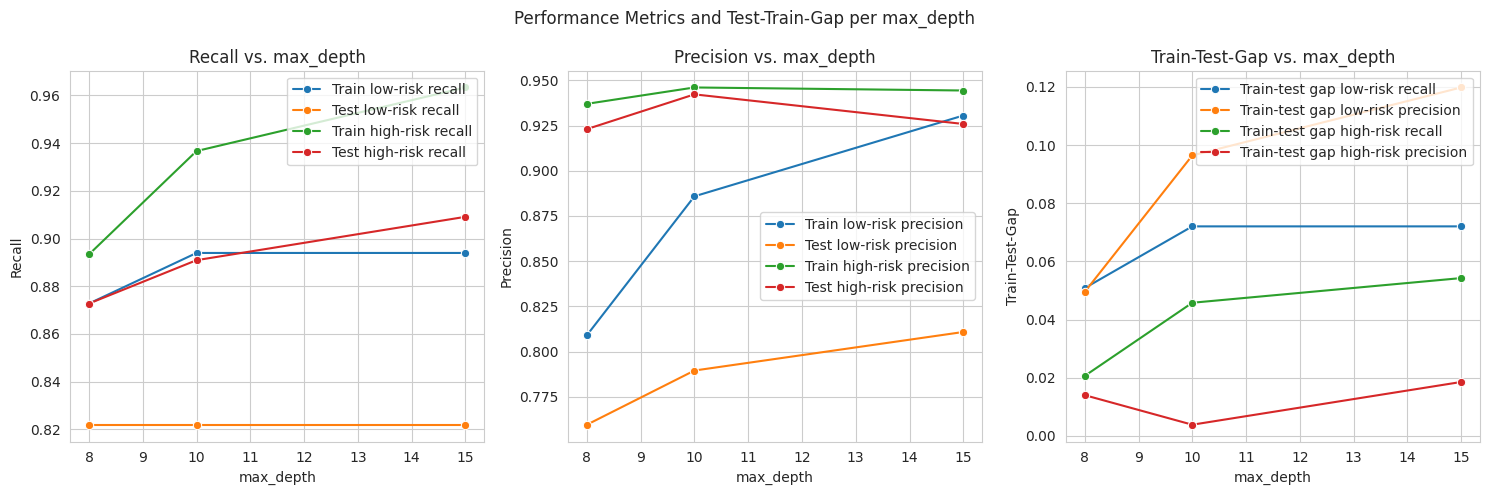

In [259]:
depths=[8,10,15]


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle("Performance Metrics and Test-Train-Gap per max_depth")

# Recall subplot
sns.lineplot(ax=axes[0], x=depths, y=report_max_depths["low risk"][report_max_depths.index.str.contains("recall_train")], label="Train low-risk recall", marker="o")
sns.lineplot(ax=axes[0], x=depths, y=report_max_depths["low risk"][report_max_depths.index.str.contains("recall_test")], label="Test low-risk recall", marker="o")
sns.lineplot(ax=axes[0], x=depths, y=report_max_depths["high risk"][report_max_depths.index.str.contains("recall_train")], label="Train high-risk recall", marker="o")
sns.lineplot(ax=axes[0], x=depths, y=report_max_depths["high risk"][report_max_depths.index.str.contains("recall_test")], label="Test high-risk recall", marker="o")
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall vs. max_depth')

# Precision subplot
sns.lineplot(ax=axes[1], x=depths, y=report_max_depths["low risk"][report_max_depths.index.str.contains("precision_train")], label="Train low-risk precision", marker="o")
sns.lineplot(ax=axes[1], x=depths, y=report_max_depths["low risk"][report_max_depths.index.str.contains("precision_test")], label="Test low-risk precision", marker="o")
sns.lineplot(ax=axes[1], x=depths, y=report_max_depths["high risk"][report_max_depths.index.str.contains("precision_train")], label="Train high-risk precision", marker="o")
sns.lineplot(ax=axes[1], x=depths, y=report_max_depths["high risk"][report_max_depths.index.str.contains("precision_test")], label="Test high-risk precision", marker="o")
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs. max_depth')

sns.lineplot(ax=axes[2], x=depths, y=report_max_depths["low risk"][report_max_depths.index.str.contains("recall_gap")], label="Train-test gap low-risk recall", marker="o")
sns.lineplot(ax=axes[2], x=depths, y=report_max_depths["low risk"][report_max_depths.index.str.contains("precision_gap")], label="Train-test gap low-risk precision", marker="o")
sns.lineplot(ax=axes[2], x=depths, y=report_max_depths["high risk"][report_max_depths.index.str.contains("recall_gap")], label="Train-test gap high-risk recall", marker="o")
sns.lineplot(ax=axes[2], x=depths, y=report_max_depths["high risk"][report_max_depths.index.str.contains("precision_gap")], label="Train-test gap high-risk precision", marker="o")
axes[2].set_xlabel('max_depth')
axes[2].set_ylabel('Train-Test-Gap')
axes[2].set_title('Train-Test-Gap vs. max_depth')


plt.tight_layout()
plt.show()

#### Train-Test-Gap Considerations

Note these are old notes from a study without winsorizing. To do: write up new considerations and conclusions!



Let us compare the results for max_depth of 12 (with better performance overall but a higher train-test-gap) and max_depth 8 (with dropped performance but smaller train-test-gap):

* RandomForestClassifier with max_depth 12:
  * train set high-risk recall: 88%
  * test set high-risk recall: 78%
  * difference: 10 percentage points
* RandomForestClassifier with max_depth 8:
  * train set high-risk recall: 82%
  * test set high-risk recall: 75%
  * difference: 7 percentage points

When decreasing the max depth of the RandomForest decision trees:
* train set high-risk recall scores decrease by 6 percentage points, this seems like a larger drop, but it looks like overfitting could be reduced.
* test set high-risk recall scores decrease by 3 percentage points, this is only a small drop and the test set high-risk recall is what we aim to optimize!
* Hence the difference decreases by 3 percentage points, which is good.

#### Decision

Is the improvement in train-test gap worth the overall drop in model performance?

In our case we decide, that yes, this is worth it for better robustness and a
more reliable and generalizable model. The drop in test case recall is only
3 percentage points, and this is the relevant set, since the model will need to
predict reliably on new and unseen data.

So we continue with the RandomForestClassifier optimized for averaged high-risk recall and with max_depth of 8.

Note that we performed many more hyperparameter optimization searches and these are the most promising results we could find for our dataset.
Although in a real world project in the medical field even higher scores would be the goal. We are limited by a relatively small dataset.
The scores we reach here are still very good and fulfill the requirements stated in the business case.

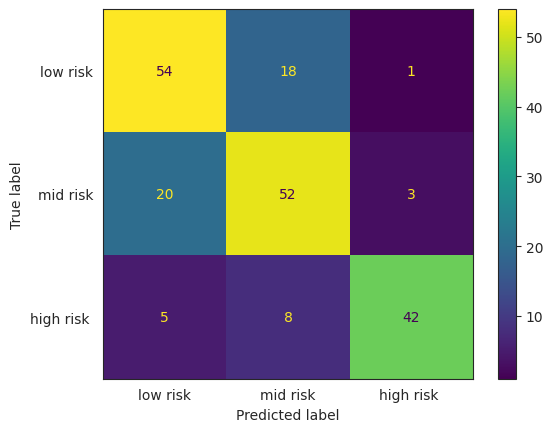

In [52]:
sns.set_style("white")

predictions = pipeline_clf_rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=pipeline_clf_rf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low risk", "mid risk", "high risk "])
disp.plot()
plt.show()

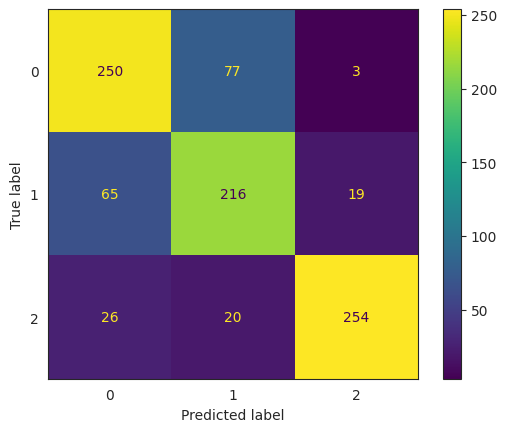

In [115]:
predictions = pipeline_clf_rf.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=pipeline_clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_clf_rf.classes_)
disp.plot()
plt.show()

# Conclusions